In [5]:
import Pkg

packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
    "Accessors",
    "KrylovKit",
    "Statistics"
]

Pkg.add(packages) 

using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 
using Accessors
using KrylovKit
using Statistics

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


Running Scaling Analysis: Distortion vs Gamma3 (at Omega=1.1)...
  Warming up initial guess...
198.035553 seconds (21.48 M allocations: 26.317 GiB, 3.48% gc time, 1.68% compilation time: 12% of which was recompilation)


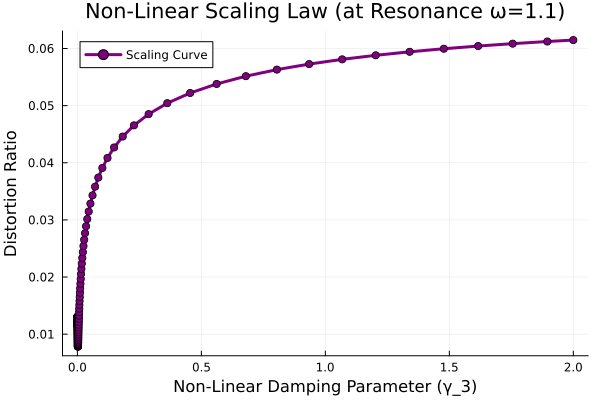

In [6]:
# 1. Define the PDE 
function wave_equation_1d!(du, u, p, t)
    N = p.N; dx = p.dx; c2 = p.g * p.H
    eta = @view u[1:N]; v = @view u[N+1:2N]
    d_eta = @view du[1:N]; d_v = @view du[N+1:2N]
    
    for i in 1:N
        d_eta[i] = v[i]
        eta_L = (i==1) ? 0.0 : eta[i-1]
        eta_R = (i==N) ? 0.0 : eta[i+1]
        
        lap = (eta_R - 2*eta[i] + eta_L) / (dx^2)
        damping = p.gamma * v[i] + p.gamma3 * v[i]^3
        forcing = p.F0 * sin(p.omega * t)
        
        d_v[i] = c2 * lap + forcing - damping 
    end
end 

# 2. Parameters
L = 10.0; N = 10; dx = L / (N + 1)
par_base = (N=N, dx=dx, g=9.81, H=1.5, gamma=0.05, gamma3=0.0, F0=5.0, omega=1.1)

# 3. Poincaré Map
function poincare_map_wave(u, p)
    T = 2π / abs(p.omega)
    prob = ODEProblem(wave_equation_1d!, u, (0.0, T), p)
    sol = solve(prob, Rodas4(), reltol=1e-8, abstol=1e-8, save_everystep=false)
    return sol[end] - u
end 

# 4. Scaling Analysis Runner 
function run_scaling_analysis()
    println("Running Scaling Analysis: Distortion vs Gamma3 (at Omega=1.1)...")
    
    # Start with Gamma3 = 0.0 
    par_start = par_base 
    u0 = zeros(2*N) 
    
    # 1. Warm-up to get a stable limit cycle at gamma3=0
    println("  Warming up initial guess...")
    T_warm = 20 * (2π/par_start.omega)
    prob_warm = ODEProblem(wave_equation_1d!, u0, (0.0, T_warm), par_start)
    u0_steady = solve(prob_warm, Tsit5(), reltol=1e-6, abstol=1e-6)[end]

    # 2. Define Bifurcation Problem
    prob = BifurcationProblem(poincare_map_wave, u0_steady, par_start, (@optic _.gamma3);
        record_from_solution = (x, p; k...) -> begin
            gamma3_current = (p isa Real) ? p : p.gamma3
            
            # Reconstruct full parameter set
            p_full = merge(par_start, (gamma3 = Float64(gamma3_current),))
            
            # Run one full cycle at high res
            T = 2π / p_full.omega
            prob_rec = ODEProblem(wave_equation_1d!, x, (0.0, T), p_full)
            sol_rec = solve(prob_rec, Tsit5(), saveat=T/64, reltol=1e-8)
            
            # Extract Signal
            mid_idx = Int(div(p_full.N, 2))
            signal = [sol_rec.u[i][mid_idx] for i in 1:length(sol_rec.t)]
            
            # Compute Distortion
            signal .-= mean(signal)
            spectrum = abs.(rfft(signal))
            
            fundamental = spectrum[2]
            harmonic_3rd = (length(spectrum) >= 4) ? spectrum[4] : 0.0
            
            distortion_metric = harmonic_3rd / fundamental
            return distortion_metric
        end
    )

    # 3. Continuation Options
    opts = ContinuationPar(
        p_min=0.0, p_max=2.0, 
        ds=0.05, dsmax=0.1, 
        max_steps=4000, 
        detect_bifurcation=0
    )
    
    return continuation(prob, PALC(), opts)
end

# 4. Execution
@time branch_scaling = run_scaling_analysis()

# 5. Plotting 
p_scale = plot(branch_scaling, 
    title = "Non-Linear Scaling Law (at Resonance ω=1.1)",
    xlabel = "Non-Linear Damping Parameter (γ_3)",
    ylabel = "Distortion Ratio",
    label = "Scaling Curve", 
    lw = 3, color = :purple,
    marker = :circle,
    legend = :topleft,
    grid = true
)

display(p_scale)